### Importing Libraries

In [1]:
import numpy as np
import dicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
from matplotlib.patches import Ellipse
from skimage import io, color, measure, draw, img_as_bool
from scipy import optimize
import pandas as pd

### Importing Data from a folder which contains all DCM files

In [9]:
data_path = "/home/ctuser/myData/images/"
output_path = working_path = "/home/ctuser/Desktop/Semantic_Seg/data"
g = glob(data_path + "/*")

print("Total no. of CT images are: %d \nFirst 5 elements:" %len(g))
print '\n'.join(g[:5])

Total no. of CT images are: 2490 
First 5 elements:
/home/ctuser/myData/images/i40419.CTDC.2
/home/ctuser/myData/images/i144260.CTDC.70
/home/ctuser/myData/images/i79048.CTDC.27
/home/ctuser/myData/images/i8311.CTDC.11
/home/ctuser/myData/images/i145285.CTDC.103


#### Loading CT Scan Images and calculate HU units for each pixels

In [10]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

id=438
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

#### saving output images in Hounsfield Units

In [11]:
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

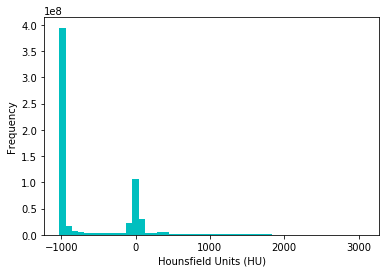

In [12]:
file_used=output_path+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [13]:
id = 438
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

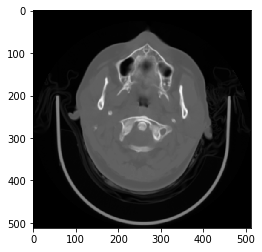

In [14]:
a = imgs_to_process[6]
fig,ax = plt.subplots(1)
ax.imshow(a,cmap=plt.cm.gray)
#ellipse = Ellipse(xy=(256,246), width=380, height=430, edgecolor='r',fill=False, lw=1)
#ax.add_patch(ellipse)
plt.show()

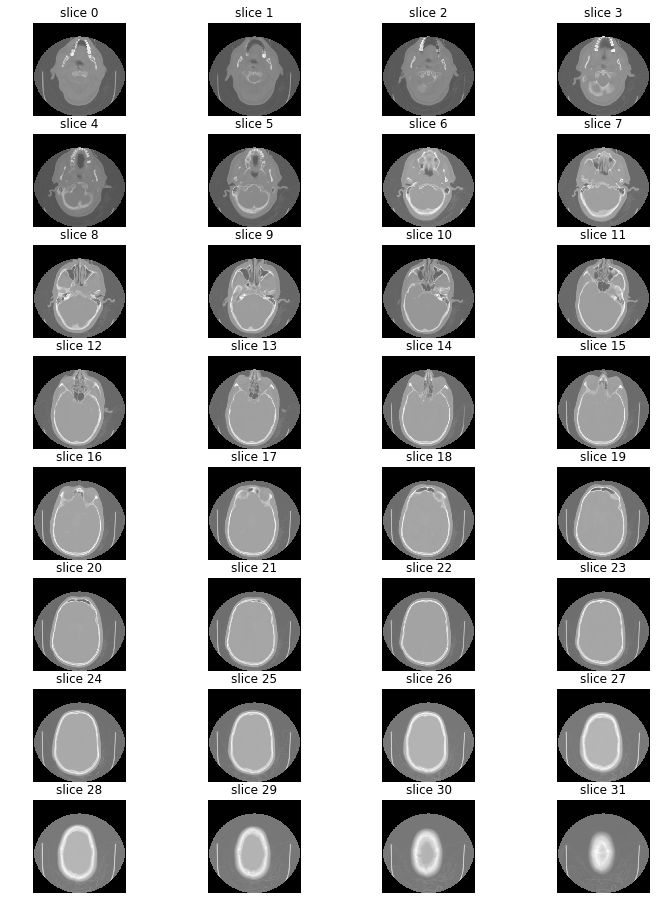

In [64]:
def sample_stack(stack, rows=8, cols=4):
    fig,ax = plt.subplots(rows,cols,figsize=[12,16])
    for i in range(rows*cols):
        ax[int(i/cols),int(i % cols)].set_title('slice %d' % i)
        ax[int(i/cols),int(i % cols)].imshow(stack[i],cmap='gray')
        ax[int(i/cols),int(i % cols)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

#### A Static Elliptic filter to remove head rest

In [ ]:
def filter_ellipse(imgs_array):
    for a in imgs_array:
        o,p=256,246
        arr_x,arr_y=512.0,512.0
        y,x = np.ogrid[0.0:512.0,0.0:512.0]
        mask = ((x-256.0)*(x-256.0))/(190.0*190.0) + ((y-246.0)*(y-246.0))/(215.0*215.0) > 1.0
        a[mask] = -1000
    return(imgs_array,mask)
    
ad = filter_ellipse(imgs_to_process)

#### A Linear Elliptic filter to remove head rest

In [ ]:
def filter_linear(imgs_array):
    for a in imgs_array:
        for j in range(100,450):
            for i in range(400,512):
                c=np.mean(np.array(a[j,i-20:i]))
                if c<=-999:
                    a[j,i:512]=-1000
        for j in range(100,450):
            for i in range(0,100):
                c=np.mean(np.array(a[j,i:i+20]))
                if c<=-999:
                    a[j,0:i]=-1000
            
        for i in range(0,512):
            for j in range(450,512):
                c = np.mean(np.array(a[j:j+20,i]))
                if c<=-999:
                    a[j:512,i]=-1000
                else:
                    d = np.mean(np.array(a[j-20:j,i]))
                    if d<=-999:
                        a[j:512,i]=-1000
    return(imgs_array)
imgs_to_process_1inear_filter = filter_linear(imgs_to_process)

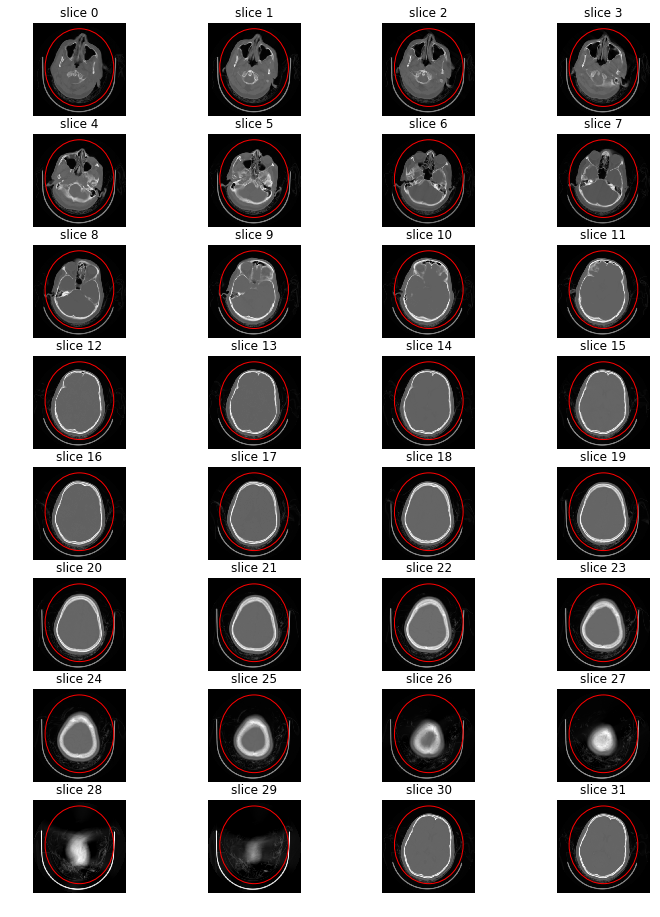

In [19]:
def sample_stack(stack, rows=8, cols=4):
    fig,ax = plt.subplots(rows,cols,figsize=[12,16])
    for i in range(rows*cols):
        ax[int(i/cols),int(i % cols)].set_title('slice %d' % i)
        ax[int(i/cols),int(i % cols)].imshow(stack[i],cmap='gray')
        ax[int(i/cols),int(i % cols)].axis('off')
        ellipse = Ellipse(xy=(256,246), width=380, height=430, edgecolor='r',fill=False, lw=1)
        ax[int(i/cols),int(i % cols)].add_patch(ellipse)
    plt.show()

sample_stack(imgs_to_process)

In [ ]:
a = imgs_to_process[4]

In [ ]:
fig,ax = plt.subplots(1)
ax.imshow(a,cmap=plt.cm.gray)
ellipse = Ellipse(xy=(256,246), width=380, height=430, edgecolor='r',fill=False, lw=1)
ax.add_patch(ellipse)
plt.show()

#### Optimal Ellipse fitting 

In [ ]:
a=imgs_to_process[16]

In [ ]:
image = np.int16(dilated)
regions = measure.regionprops(label_image=image)
bubble = regions[0]

r, c = bubble.centroid
r_radius = bubble.major_axis_length / 2.
c_radius = bubble.minor_axis_length / 2.

def cost(params):
    r,c,r_radius,c_radius = params
    coords = draw.ellipse(r, c, r_radius,c_radius, shape=image.shape)
    template = np.zeros_like(image)
    template[coords] = 0
    return -np.sum(template == image)

r,c,r_radius,c_radius = optimize.fmin(cost, (r,c,r_radius,c_radius))

import matplotlib.pyplot as plt

f, ax = plt.subplots()
ellipse = Ellipse(xy=(r,c), width=2*c_radius, height=2*r_radius,fill=True,lw=5,edgecolor='r')
ax.imshow(image, cmap='gray', interpolation='nearest')
ax.add_artist(ellipse)
plt.show()

In [ ]:
fig,ax = plt.subplots(1)
ax.imshow(a,cmap=plt.cm.gray)
plt.show()

In [ ]:
image = a
regions = measure.regionprops(image)
bubble = regions[0]

y0, x0 = bubble.centroid
r = bubble.major_axis_length / 2.

def cost(params):
    x0, y0, r = params
    coords = draw.circle(y0, x0, r, shape=image.shape)
    template = np.zeros_like(image)
    template[coords] = 1
    return -np.sum(template == image)

x0, y0, r = optimize.fmin(cost, (x0, y0, r))

import matplotlib.pyplot as plt

f, ax = plt.subplots()
circle = plt.Circle((x0, y0), r)
ax.imshow(image, cmap='gray', interpolation='nearest')
ax.add_artist(circle)
plt.show()

In [ ]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))
    print(spacing)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print "Shape before resampling\t", imgs_to_process.shape
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print "Shape after resampling\t", imgs_after_resamp.shape

In [15]:
def min_distance(df):
    lst = np.array(df['HU_Value'])
    aggg=0
    bggg=0
    ccc=[]
    lst = sorted(lst)
    index=-1
    distance = max(lst)-min(lst)
    for i in range(len(lst)-1):
        if lst[i+1] - lst[i] < distance:
            distance = lst[i+1] - lst[i] 
            index = i
    for i in range(len(lst)-1):
        if lst[i+1] - lst[i] == distance:
            id_1 = lst[i]
            id_2 = lst[i+1]
            if lst[i]==lst[i+1]:
                aggg = np.array(df['label'][df['HU_Value']==lst[i]])
                bggg = aggg[1]
                aggg = aggg[0]
            else:
                aggg = df['label'][df['HU_Value']==lst[i]]
                bggg = df['label'][df['HU_Value']==lst[i+1]]
    return  aggg,bggg,distance

In [16]:
def find_headrest_label(std_table,mean_table,labels):
    labels_vals = np.unique(labels)
    #print("iteration 0 initiated:\n")
    throw_label=[]
    e1 =pd.DataFrame(mean_table[(mean_table['HU_Value']>=-50) & (mean_table['HU_Value']<290)])
    e3 =pd.DataFrame(mean_table[(mean_table['HU_Value']>=120) & (mean_table['HU_Value']<290)])
    connected_headrest_label_1 = e3['label'].values
    sel_label=e1['label'].values
    e2 =pd.DataFrame(std_table[std_table['label'].isin(sel_label)])
    #print(e2)
    e4 =pd.DataFrame(std_table[(std_table['HU_Value']>150) & (std_table['HU_Value']<300)])
    connected_headrest_label_2 = e4['label'].values
    #print("Iteration 1 initiated:\n")
    y=0
    while(y==0):
        if np.array(e2['HU_Value']).size == 1:
            break
        t1,t2,filt = min_distance(e2)
        #print(t1)
        #print(t2)
        t1 = np.int(t1)
        t2 = np.int(t2)
        if filt<15:
            throw_label.append(t1)
            throw_label.append(t2)
            e2 = e2[~e2['label']==t1]
        else:
            y=y+1
        if np.array(e2['HU_Value']).size == 1:
            break
        if np.array(e2['HU_Value']).size == 0:
            break
    print('--------------------------------------------\n')
    if len(throw_label)==0:
        if len(connected_headrest_label_1)==1:
            throw_label.append(np.int(connected_headrest_label_1))
        else:
            b3 = np.array([val for val in connected_headrest_label_1 if val in connected_headrest_label_2])
            if len(b3)!=0:
                throw_label.append(np.int(b3))
    return(throw_label)

In [17]:
def find_headrest_label(std_table,mean_table,labels):
    labels_vals = np.unique(labels)
    #print("iteration 0 initiated:\n")
    throw_label=[]
    e1 =pd.DataFrame(mean_table[(mean_table['HU_Value']>=-100) & (mean_table['HU_Value']<400)])
    e3 =pd.DataFrame(mean_table[(mean_table['HU_Value']>=120) & (mean_table['HU_Value']<400)])
    #print(e3)
    connected_headrest_label_1 = np.array(e3['label'].values)
    #print(connected_headrest_label_1)
    #print("length of connected_headrest_label_1 " ,len(connected_headrest_label_1))
    sel_label=e1['label'].values
    e2 =pd.DataFrame(std_table[std_table['label'].isin(sel_label)])
    #print(e2)
    e4 =pd.DataFrame(std_table[(std_table['HU_Value']>150) & (std_table['HU_Value']<300)])
    #print(e4)
    connected_headrest_label_2 = np.array(e4['label'].values)
    #print(connected_headrest_label_2)
    #print("Iteration 1 initiated:\n")
    y=0
    while(y==0):
        if np.array(e2['HU_Value']).size == 1:
            break
        t1,t2,filt = min_distance(e2)
        #print(t1)
        #print(t2)
        t1 = np.int(t1)
        t2 = np.int(t2)
        if filt<=50:
            throw_label.append(t1)
            throw_label.append(t2)
            e2 = e2[~e2['label']==t1]
        else:
            y=y+1
        if np.array(e2['HU_Value']).size == 1:
            break
        if np.array(e2['HU_Value']).size == 0:
            break
    print('--------------------------------------------\n')
    if len(throw_label)==0:
        if len(connected_headrest_label_1)==1:
            #print("-----------------aaaaaaaaaaalllllllllll---------------")
            throw_label.append(np.int(connected_headrest_label_1))
        else:
            b3 = np.array([val for val in connected_headrest_label_1 if val in connected_headrest_label_2])
            #print("-------------bjfbej-------------")
            print(b3)
            if len(b3)!=0:
                throw_label.append(np.int(b3))
    return(throw_label)

def remove_headrest(img, display=False):
    img_2 = img
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    #middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    #mean = np.mean(middle)  
    #max = np.max(img)
    #min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    #img[img==max]=mean
    #img[img==min]=mean
    
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    
    kmeans = KMeans(n_clusters=2).fit(np.reshape(img,[np.prod(img.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,0,1)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.
    #eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    #dilation = morphology.dilation(thresh_img,np.ones([1,1]))

    labels = measure.label(thresh_img,neighbors=8,connectivity=2)
    region = measure.regionprops(labels,img_2)
    
    
    label_vals = np.unique(labels)
    #print(label_vals)
    smallest_distance=100000000000000
    head_label=0
    for lab in np.unique(labels):
        cent_x,cent_y = region[lab-1].centroid
        dist = distance(cent_x,cent_y)
        if smallest_distance>dist:
            smallest_distance=dist
            head_label = lab
    ## we got the head label.
    #print('\n -------------------------------------------')
    labels_flat = labels.reshape(np.prod(labels.shape),1)
    labels_flat = pd.DataFrame(labels_flat)
    labels_flat.columns=['label']

    img_2_flat = np.array(np.reshape(img_2,[np.prod(img_2.shape),1]))
    img_2_flat = pd.DataFrame(img_2_flat)
    img_2_flat.columns = ['HU_Value']

    df=pd.DataFrame.join(labels_flat,img_2_flat)

    std = pd.DataFrame(df.groupby('label').std())
    std = std[np.isfinite(std['HU_Value'])]

    std = pd.DataFrame(std,dtype="int")
    std.reset_index(level=0, inplace=True)
    std_input = std[std['label']!=head_label]
    mea = pd.DataFrame(df.groupby('label').mean(),dtype='int')
    mea.reset_index(level=0, inplace=True)
    mea_input = mea[mea['label']!=head_label]
    #print("Std Table: ")
    #print std_input
    #print head_label,"gfeyufgefueheiuf"
    #print std
    #print("Mean Table: ")
    #print mea_input
    throw_label = find_headrest_label(labels=labels,mean_table=mea_input,std_table=std_input)
    
    if len(throw_label)==0:
        print("Raised an error: Your algorithm can not successfully filter the labels")
        return(0)
    
    #labels[labels==0]=head_label
    for lab in throw_label:
        labels[labels==lab]=0
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 1
    mask[labels==0]= 0
    #for N in labels:
    #    mask = mask + np.where(labels==N,1,0)
    #print(np.unique(mask))
    mask = morphology.dilation(mask,np.ones([15,15])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3,2, figsize=[12, 12])
        ax[0,0].set_title("Original")
        ax[0,0].imshow(img, cmap='gray')
        ax[0,0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(thresh_img, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2,1].imshow(mask*img, cmap='gray')
        ax[2,1].axis('off')
       
        plt.show()
    return (0)

In [ ]:
img = imgs_to_process[23]
#i=0
#for img in imgs_to_process:
   # print("slice %d :" %i)
dilated = remove_headrest(img, display=True)
    #i+=1

In [ ]:
#img = imgs_to_process[32]
#i=0
for img in imgs_to_process:
    print("slice %d :" %i)
    dilated = headrest_segmented_filter(img, display=True)
    i+=1

In [19]:
def distance(x,y):
    dist = np.sqrt((x-256.)*(x-256.) + (y-256.)*(y-256.))
    return dist
def min_distance(df):
    lst = np.array(df['HU_Value'])
    aggg=0
    bggg=0
    ccc=[]
    lst = sorted(lst)
    index=-1
    distance = max(lst)-min(lst)
    for i in range(len(lst)-1):
        if lst[i+1] - lst[i] < distance:
            distance = lst[i+1] - lst[i] 
            index = i
    for i in range(len(lst)-1):
        if lst[i+1] - lst[i] == distance:
            id_1 = lst[i]
            id_2 = lst[i+1]
            if lst[i]==lst[i+1]:
                aggg = np.array(df['label'][df['HU_Value']==lst[i]])
                bggg = aggg[1]
                aggg = aggg[0]
            else:
                aggg = df['label'][df['HU_Value']==lst[i]]
                bggg = df['label'][df['HU_Value']==lst[i+1]]
    return  aggg,bggg,distance

def find_headrest_label(std_table,mean_table,labels):
    labels_vals = np.unique(labels)
    #print("iteration 0 initiated:\n")
    throw_label=[]
    e1 =pd.DataFrame(mean_table[(mean_table['HU_Value']>=-50) & (mean_table['HU_Value']<400)])
    e3 =pd.DataFrame(mean_table[(mean_table['HU_Value']>=120) & (mean_table['HU_Value']<400)])
    #print(e3)
    connected_headrest_label_1 = np.array(e3['label'].values)
    #print(connected_headrest_label_1)
    #print("length of connected_headrest_label_1 " ,len(connected_headrest_label_1))
    sel_label=e1['label'].values
    e2 =pd.DataFrame(std_table[std_table['label'].isin(sel_label)])
    #print(e2)
    e4 =pd.DataFrame(std_table[(std_table['HU_Value']>150) & (std_table['HU_Value']<300)])
    #print(e4)
    connected_headrest_label_2 = np.array(e4['label'].values)
    #print(connected_headrest_label_2)
    #print("Iteration 1 initiated:\n")
    y=0
    while(y==0):
        if np.array(e2['HU_Value']).size == 0:
            break
        if np.array(e2['HU_Value']).size == 1:
            break
        t1,t2,filt = min_distance(e2)
        #print(t1)
        #print(t2)
        t1 = np.int(t1)
        t2 = np.int(t2)
        if filt<=50:
            throw_label.append(t1)
            throw_label.append(t2)
            e2 = e2[~e2['label']==t1]
        else:
            y=y+1
        if np.array(e2['HU_Value']).size == 1:
            break
        if np.array(e2['HU_Value']).size == 0:
            break
    print('--------------------------------------------\n')
    if len(throw_label)==0:
        if len(connected_headrest_label_1)==1:
            #print("-----------------aaaaaaaaaaalllllllllll---------------")
            throw_label.append(np.int(connected_headrest_label_1))
        else:
            b3 = np.array([val for val in connected_headrest_label_1 if val in connected_headrest_label_2])
            #print("-------------bjfbej-------------")
            print(b3)
            if len(b3)!=0:
                throw_label.append(np.int(b3))
    return(throw_label)

def remove_headrest(img, display=False):
    img_2 = img
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    #middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    #mean = np.mean(middle)  
    #max = np.max(img)
    #min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    #img[img==max]=mean
    #img[img==min]=mean
    
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    
    kmeans = KMeans(n_clusters=2).fit(np.reshape(img,[np.prod(img.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,0,1)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.
    #eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    #dilation = morphology.dilation(thresh_img,np.ones([1,1]))

    labels = measure.label(thresh_img,neighbors=8,connectivity=2)
    region = measure.regionprops(labels,img_2)
    
    
    label_vals = np.unique(labels)
    #print(label_vals)
    smallest_distance=100000000000000
    head_label=0
    for lab in np.unique(labels):
        cent_x,cent_y = region[lab-1].centroid
        dist = distance(cent_x,cent_y)
        if smallest_distance>dist:
            smallest_distance=dist
            head_label = lab
    ## we got the head label.
    #print('\n -------------------------------------------')
    labels_flat = labels.reshape(np.prod(labels.shape),1)
    labels_flat = pd.DataFrame(labels_flat)
    labels_flat.columns=['label']

    img_2_flat = np.array(np.reshape(img_2,[np.prod(img_2.shape),1]))
    img_2_flat = pd.DataFrame(img_2_flat)
    img_2_flat.columns = ['HU_Value']

    df=pd.DataFrame.join(labels_flat,img_2_flat)

    std = pd.DataFrame(df.groupby('label').std())
    std = std[np.isfinite(std['HU_Value'])]

    std = pd.DataFrame(std,dtype="int")
    std.reset_index(level=0, inplace=True)
    std_input = std[std['label']!=head_label]
    mea = pd.DataFrame(df.groupby('label').mean(),dtype='int')
    mea.reset_index(level=0, inplace=True)
    mea_input = mea[mea['label']!=head_label]
    print("Std Table: ")
    print std_input
    print head_label,"gfeyufgefueheiuf"
    print std
    print("Mean Table: ")
    print mea_input
    throw_label = find_headrest_label(labels=labels,mean_table=mea_input,std_table=std_input)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 1
    if len(throw_label)==0:
        print("Raised an error: Your algorithm can not successfully filter the labels")
    #print head_label
    #labels[labels==0]=head_label
    else:
        for lab in throw_label:
            labels[labels==lab]=0
        mask[labels==0]= 0
    #for N in labels:
    #    mask = mask + np.where(labels==N,1,0)
    #print(np.unique(mask))
        mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3,2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(thresh_img, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
       
        plt.show()
    return (0)

In [39]:
def headrest_segmented_filter(img, display=False):
    img_2 = img
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    #middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    #mean = np.mean(middle)  
    #max = np.max(img)
    #min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    #img[img==max]=mean
    #img[img==min]=mean
    
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    
    kmeans = KMeans(n_clusters=2).fit(np.reshape(img,[np.prod(img.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,0,1)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.
    #eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    #dilation = morphology.dilation(thresh_img,np.ones([1,1]))

    labels = measure.label(thresh_img,neighbors=8,connectivity=2)
    segment_labels = np.copy(labels)
    region = measure.regionprops(labels,img_2)
    
    
    label_vals = np.unique(labels)
    #print(label_vals)
    smallest_distance=100000000000000
    head_label=0
    for lab in np.unique(labels):
        cent_x,cent_y = region[lab-1].centroid
        dist = distance(cent_x,cent_y)
        if smallest_distance>dist:
            smallest_distance=dist
            head_label = lab
    ## we got the head label.
    #print('\n -------------------------------------------')
    labels_flat = labels.reshape(np.prod(labels.shape),1)
    labels_flat = pd.DataFrame(labels_flat)
    labels_flat.columns=['label']

    img_2_flat = np.array(np.reshape(img_2,[np.prod(img_2.shape),1]))
    img_2_flat = pd.DataFrame(img_2_flat)
    img_2_flat.columns = ['HU_Value']

    df=pd.DataFrame.join(labels_flat,img_2_flat)

    std = pd.DataFrame(df.groupby('label').std())
    std = std[np.isfinite(std['HU_Value'])]

    std = pd.DataFrame(std,dtype="int")
    std.reset_index(level=0, inplace=True)
    std_input = std[std['label']!=head_label]
    mea = pd.DataFrame(df.groupby('label').mean(),dtype='int')
    mea.reset_index(level=0, inplace=True)
    mea_input = mea[mea['label']!=head_label]
    #print("Std Table: ")
    #print std_input
    #print head_label,"gfeyufgefueheiuf"
    #print std
    #print("Mean Table: ")
    #print mea_input
    throw_label = find_headrest_label(labels=labels,mean_table=mea_input,std_table=std_input)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    labels[labels==head_label]=0
    keep_label =[i for i in label_vals if i not in throw_label]
    #print keep_label
    for lab in keep_label:
        labels[labels==lab]=0
    mask[:] = 0
    #print throw_label
    if len(throw_label)==0:
        print("Raised an error: Your algorithm can not successfully filter the labels")
    else:
        for lab in throw_label:
            labels[labels==lab]=1
        mask[labels==1]= 1
    #for N in labels:
    #    mask = mask + np.where(labels==N,1,0)
    #print(np.unique(mask))
        mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(1,3, figsize=[12, 12])
        ax[0].set_title("Original")
        ax[0].imshow(img, cmap='gray')
        ax[0].axis('off')
        #ax[0, 1].set_title("Threshold")
        #ax[0, 1].imshow(thresh_img, cmap='gray')
        #ax[0, 1].axis('off')
        #ax[1, 0].set_title("After Erosion and Dilation")
        #ax[1, 0].imshow(thresh_img, cmap='gray')
        #ax[1, 0].axis('off')
        ax[1].set_title("Headrest label")
        ax[1].imshow(labels)
        ax[1].axis('off')
        ax[2].set_title("colour labels")
        ax[2].imshow(segment_labels)
        ax[2].axis('off')
        #ax[2, 1].set_title("Apply Mask on Original")
        #ax[2, 1].imshow(mask*img, cmap='gray')
        #ax[2, 1].axis('off')
       
        plt.show()
    return segment_labels, labels

--------------------------------------------



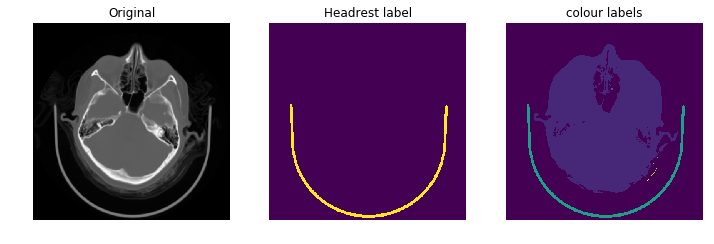

In [40]:
img = imgs_to_process[323]
#i=0
#for img in imgs_to_process:
#    print("slice %d :" %i)
segment_input_img, headrest_label = headrest_segmented_filter(img, display=True)
#    i+=1

## Creating Data for semantic Segmentation

In [ ]:
#data_path = "/home/ctuser/myData/s652/"
#output_path = working_path = "/home/ctuser/Desktop/Image_Seg/"
#g = glob(data_path + "/*")
#
#print("Total no. of CT images are: %d \nFirst 5 elements:" %len(g))
#print '\n'.join(g[:5])
#
#patient = load_scan(data_path)
#imgs = get_pixels_hu(patient)
#id = 652
#np.save(output_path + "fullimages_%d.npy" % (id), imgs)
#imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
ground_truth = np.zeros_like(imgs_to_process)
for i in range(0,imgs_to_process.shape[0]):
    ground_truth[i] = headrest_segmented_filter(imgs_to_process[i], display=True)

In [24]:
imgs_to_process.shape[0]

2490

In [29]:
imgs_to_process.shape

(2490, 512, 512)

In [ ]:
new_data = np.vstack((new_data,ground_truth))

In [ ]:
input_data = np.vstack((input_data,imgs_to_process))

In [26]:
id = 1
np.save(output_path + "train_images_groundtruth_big_%d.npy" % (id), ground_truth)

In [27]:
id = 1
np.save(output_path + "train_images_input__big_%d.npy" % (id), imgs_to_process)